In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append('../pairedRS')

In [3]:
import numpy as np   
import pandas as pd
import pdb
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from tqdm import tqdm
import sys

In [ ]:
from utils import *     # contains some useful helper functions 
from models import *    # toy models
from solvers import *   # matrix completion solvers
from methods import *

In [582]:
# Some useful functions

def get_scores(n, a=1, b=1, random_state=0):  
    rng = np.random.default_rng(random_state)
    scores = rng.beta(a, b, n)
    return scores



# Bonferroni
def get_bon_st(scores, alpha):
    st_scores = np.sort(scores)
    alpha_corrected = alpha / 2
    bon_st = np.quantile(st_scores, 1 - alpha_corrected, method="lower")
    return bon_st, st_scores



def get_conformal_st(scores, alpha, pair_method):
    if pair_method == "indep":
        # pairs are picked at random
        pairs = [[scores[2*i], scores[2*i+1]] for i in range(n//2)]
        pair_scores = [np.max(p) for p in pairs]
        
    elif pair_method == "pos_cor":
        # similar scores are grouped
        st_scores = np.sort(scores)
        pairs = [[st_scores[2*i], st_scores[2*i+1]] for i in range(n//2)]
        pair_scores = [np.max(p) for p in pairs]
    
    elif pair_method == "neg_cor":
        st_scores = np.sort(scores)
        pairs = [[st_scores[i], st_scores[-(i+1)]] for i in range(n//2)]
        pair_scores = [np.max(p) for p in pairs]
        
    st_pair_scores = np.sort(pair_scores)
    conformal_st = np.quantile(st_pair_scores, 1 - alpha, method="lower")
    return st_pair_scores, conformal_st



def plot_st(st_pair_scores, st_scores, conformal_st, bon_st, n, alpha):
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    px = np.arange(1, n//2 + 1) / (n//2)
    h_spacing = bon_st/50
    v_spacing = alpha/5
    
    
    ax[0].plot(st_pair_scores, px)
    ax[0].axhline(y=1-alpha, color='red', linestyle='--')
    ax[0].axvline(x=conformal_st, color='blue', linestyle='--')
    ax[0].set_title("Paired scores cdf")
    ax[0].set_xlabel("Paired scores")
    ax[0].set_ylabel("Quantiles")
    ax[0].plot(conformal_st, 1-alpha, 'ro')
    ax[0].annotate(f'threshold:{conformal_st:.4f}', (conformal_st-h_spacing, 0.01), fontsize=10, color='blue', ha='right')
    ax[0].annotate(f'quantile:{1-alpha:.2f}', (conformal_st-h_spacing, 1-alpha+v_spacing), fontsize=10, color='red', ha='right')
    
    x = np.arange(1, n + 1) / n
    ax[1].plot(st_scores, x)
    ax[1].axhline(y=1-alpha/2, color='red', linestyle='--', label='Vertical Line')
    ax[1].axvline(x=bon_st, color='blue', linestyle='--')
    ax[1].set_title("Scores cdf")
    ax[1].set_xlabel("Scores")
    ax[1].set_ylabel("Quantiles")
    ax[1].plot(bon_st, 1-alpha/2, 'ro')
    ax[1].annotate(f'threshold:{bon_st:.4f}', (bon_st-h_spacing, 0.01), fontsize=10, color='blue', ha='right')
    ax[1].annotate(f'quantile:{1-alpha/2:.2f}', (bon_st-h_spacing, 1-alpha/2+v_spacing), fontsize=10, color='red', ha='right')
    
    print("Paired quantile is {}, Bonferroni quantile is {}".format(conformal_st, bon_st))
    print("Interval size ratio (Bonferroni/conformal) is {}".format(bon_st/conformal_st))

# Warm up experiments

#### Consider the general setting where we have:
- n conformity-scores generated from a specific distribution.
- Method of picking the score pairs.
- Conformity-scores of the pairs by taking the maximum over the score tuples.

#### Then the confidence interval half-width are computed as following:
- Conformal method: take the 1-alpha quantile of the scores for pairs.
- Bonferroni: take the 1-alpha/2 quantile of the original scores.

#### Metric
Power gain over the Bonferroni correction is measure by the width ratio:
- Bonferroni size / conformal size 
Larger ratio corresponds to higher power gain.

#### Priliminary conclusion
Ratio is affected by two factors:
- Grouping method: if the two scores in the same pair shows high positive correlation, the power gain is more evident.
- Score distribution: if the score cdf is concave, power gain is likely to be higher; and vice versa for covex cdfs.


In [596]:
n = 1000
alpha = 0.1

# Three toy grouping method:
# "pos_cor" shows positive correlation, i.e, similar scores are grouped together
# "neg_cor" shows negative correlation, i.e, small scores are grouped with large scores.
# "indep" groups scores uniformly at random.
pair_method = "pos_cor"

# Here we generate the score cdf with beta(a,b) which controls the convexity.
a,b = 1,100 
seed = 1

scores =  get_scores(n, a, b, random_state=seed)
st_pair_scores, conformal_st = get_conformal_st(scores, alpha, pair_method)
bon_st, st_scores = get_bon_st(scores, alpha)

Paired quantile is 0.02355185887598642, Bonferroni quantile is 0.030270573835340403
Interval size ratio (Bonferroni/conformal) is 1.2852732344708644


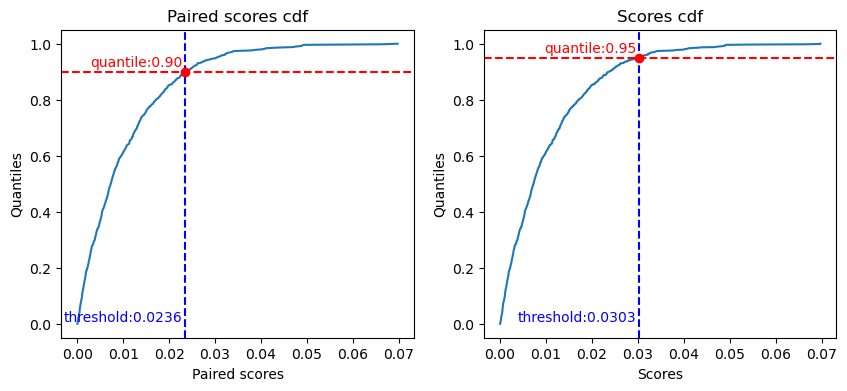

In [597]:
plot_st(st_pair_scores, st_scores, conformal_st, bon_st, n, alpha)

# Experiment with the homogeneous-pairs model

We artifically create matrix completion errors and check the tightness of the Bonferroni correction.

In [605]:
# Matrix shape and rank
n1, n2 = 100,100
r = 8
prob_obs = 0.5
random_state = 0
allow_inf = False

In [606]:
sampler = PairSampling(n1,n2)
size_obs = n1 * n2 * prob_obs
n_calib_pairs = int(size_obs//4)

# Sample observation mask
mask_obs = sampler.sample_submask(size_obs, random_state=random_state)
mask_test = np.ones_like(mask_obs) - mask_obs

# Sample calibration pairs following hpm
mask_train, idxs_calib, mask_calib, mask_drop = sampler.sample_train_calib(mask_obs, n_calib_pairs, random_state)

# Sample test pairs
n_test_pairs = min(int((np.sum(mask_test)-n1)//2), 1000)
_, idxs_test, _, _ = sampler.sample_train_calib(mask_test, n_test_pairs, random_state=random_state)

In [607]:
# Generate a random true matrix 
RFM = RandomFactorizationModel(n1 ,n2, r)
U, V, M = RFM.sample_noiseless(random_state)

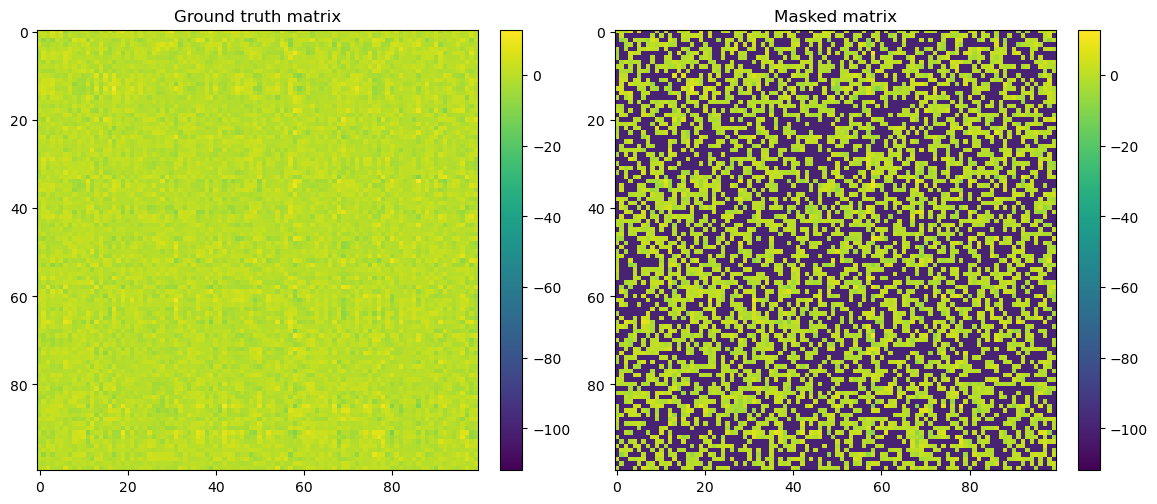

Missing entries are masked in dark color.
Observation size: 5000.0, training size: 2500.0, calib size: 2500.0, calib pairs: 1250


In [609]:
assert np.all(mask_train+mask_calib==mask_obs),'Sampling error!'
vmin, vmax = np.min(M)-100, np.max(M)
plot_before_after_mask(M, mask_obs, vmin, vmax)
print("Missing entries are masked in dark color.")
print("Observation size: {}, training size: {}, calib size: {}, calib pairs: {}"
      .format(np.sum(mask_obs), np.sum(mask_train), np.sum(mask_calib), n_calib_pairs))

In [614]:
def noisy_oracle(M, a=1, b=1, gamma=0.9, random_state=0):
    rng = np.random.default_rng(random_state)
    
    n1, n2 = M.shape
    
    # Generate noise with beta distribution, each row has the same residual 
    row_residual = rng.beta(a,b,n1)
    residual = np.transpose(np.tile(row_residual, (n2,1)))
    residual /= np.max(residual)     # normalize
     
    # Generate gaussian noise independent at each entry
    noise = rng.normal(0,1,M.shape)
    noise /= np.max(np.abs(noise))   # normalize
    
    # add a tunning parameter to control the correlation within entries in each row
    Mhat = M + gamma*residual + (1-gamma)*noise
    
    return Mhat

In [633]:
# Toggle gamma to see the row wise correlation
Mhat =  noisy_oracle(M, a=0.1, b=100, gamma=0.99, random_state=0)

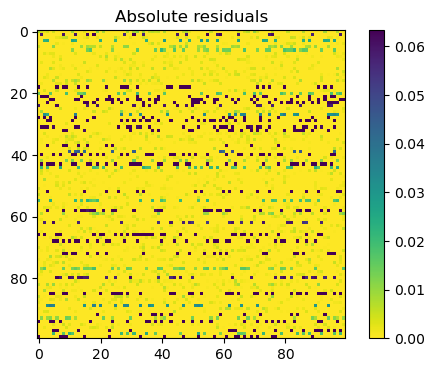

In [634]:
# some rows have larger residuals
error_heatmap(M, Mhat, mask_calib)

In [622]:
methods = [
    "conformal",      
    "naive",          # Naive conformal assuming all pairs are exchangeable 
    "bonferroni",     
    "uncorrected" 
]

In [621]:
res = pd.DataFrame({})

for method in methods:
    is_inf = np.zeros(n_test_pairs)
    if method == "conformal":
        ci_method = PairedCI_hpm(M, Mhat, mask_obs, idxs_calib)
        lower, upper, is_inf, _ = ci_method.get_CI(idxs_test, alpha, allow_inf)
    elif method == "naive":
        ci_method = PairedCI_hpm(M, Mhat, mask_obs, idxs_calib)
        lower, upper = ci_method.naive_CI(idxs_test, alpha)       
    elif method == "bonferroni":
        lower, upper = benchmark_CI(M, Mhat, idxs_calib, idxs_test, alpha)
    else:
        lower, upper = benchmark_CI(M, Mhat, idxs_calib, idxs_test, 2 * alpha)

    res = pd.concat([res, evaluate_pairedCI(lower, upper, M, idxs_test, is_inf=is_inf, method=method)])
    
res['Calib_size'] = n_calib_pairs
res['Train_size'] = np.sum(mask_train)
res['Test_size'] = n_test_pairs

Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 120.88it/s]

Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!


In [623]:
res

,Pair_coverage,Coverage,Size,Inf_prop,Method,Calib_size,Train_size,Test_size
0,0.897,0.900,0.310964,0.0,conformal,1250,2500.0,1000
0,0.897,0.900,0.310920,0.0,naive,1250,2500.0,1000
0,0.946,0.949,0.465283,0.0,bonferroni,1250,2500.0,1000
0,0.897,0.898,0.308447,0.0,uncorrected,1250,2500.0,1000


In [628]:
st_pair_scores = ci_method.st_calib_scores
conformal_st = np.quantile(st_pair_scores, 1 - alpha, method="lower")

scores = np.abs((M-Mhat)[np.where(mask_calib==1)])
bon_st, st_scores = get_bon_st(scores, alpha)

Paired quantile is 0.15546024085552068, Bonferroni quantile is 0.23264139202606593
Interval size ratio (Bonferroni/conformal) is 1.4964687481879995


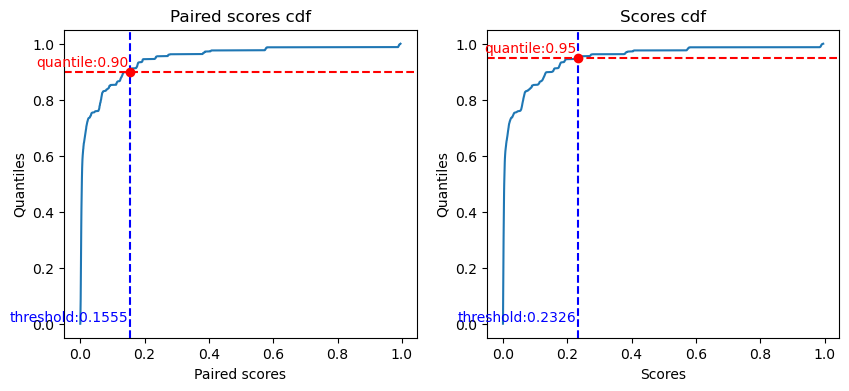

In [629]:
plot_st(st_pair_scores, st_scores, conformal_st, bon_st, len(st_scores), alpha)

## Repeated experiments

We now examine the tightness of Bonferroni benchmark by changing:
- Beta(a,b) which is the cdf of the residuals
- gamma which controls the pair-wise correlation

##### Note that the true matrix is fixed as the residual is artifically generated and does not depend on the true data matrix. 

In [641]:
def run_experiment(M, a, b, gamma, random_state=0):
    #------------------#
    # Fixed parameters #
    #------------------#
    n1, n2 = M.shape
    prob_obs = 0.5
    allow_inf = False
    
    methods = [
    "conformal",      
    "naive",          # Naive conformal assuming all pairs are exchangeable 
    "bonferroni",     
    "uncorrected" 
    ]
    
    #---------------------------------#
    # Sample masks, calib, test pairs #
    #---------------------------------#
    sampler = PairSampling(n1,n2)
    size_obs = n1 * n2 * prob_obs
    n_calib_pairs = int(size_obs//4)

    # Sample observation mask
    mask_obs = sampler.sample_submask(size_obs, random_state=random_state)
    mask_test = np.ones_like(mask_obs) - mask_obs

    # Sample calibration pairs following hpm
    mask_train, idxs_calib, mask_calib, mask_drop = sampler.sample_train_calib(mask_obs, n_calib_pairs, random_state)
    
    # Sample test pairs
    n_test_pairs = min(int((np.sum(mask_test)-n1)//2), 1000)
    _, idxs_test, _, _ = sampler.sample_train_calib(mask_test, n_test_pairs, random_state=random_state)
    
    
    #---------------------#
    # Generate estimation #
    #---------------------#
    Mhat =  noisy_oracle(M, a, b, gamma, random_state=0)
    
    
    #------------------#
    # Apply CI methods #
    #------------------#
    res = pd.DataFrame({})
    
    for method in methods:
        is_inf = np.zeros(n_test_pairs)
        if method == "conformal":
            ci_method = PairedCI_hpm(M, Mhat, mask_obs, idxs_calib)
            lower, upper, is_inf, _ = ci_method.get_CI(idxs_test, alpha, allow_inf) 
        elif method == "naive":
            ci_method = PairedCI_hpm(M, Mhat, mask_obs, idxs_calib)
            lower, upper = ci_method.naive_CI(idxs_test, alpha)       
        elif method == "bonferroni":
            lower, upper = benchmark_CI(M, Mhat, idxs_calib, idxs_test, alpha)
        else:
            lower, upper = benchmark_CI(M, Mhat, idxs_calib, idxs_test, 2 * alpha)

        res = pd.concat([res, evaluate_pairedCI(lower, upper, M, idxs_test, is_inf=is_inf, method=method)])

    
    res['Calib_size'] = n_calib_pairs
    res['Train_size'] = np.sum(mask_train)
    res['Test_size'] = n_test_pairs
    res['a'] = a
    res['b'] = b
    res['gamma'] = gamma
    res['random_state'] = random_state
    
    return res

# Experiment 1
Change a, fix b and gamma

In [653]:
# Experiment parameters
a_list = [0.1, 0.3, 0.5, 0.7, 1, 10, 30]
b=100
gamma=0.99
repetition=10

In [654]:
result = pd.DataFrame({})
for a in a_list:
    for i in range(repetition):
        res = run_experiment(M, a, b, gamma, random_state=i)
        result = pd.concat([result, res])

Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.39it/s]

Done!
Computing naive prediction intervals for 1000 test pairs...


Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!
Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.59it/s]

Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...


Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!
Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.67it/s]

Done!
Computing naive prediction intervals for 1000 test pairs...


Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!
Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.21it/s]

Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...


Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!
Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 123.23it/s]

Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!


Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 127.95it/s]

Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!


Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 127.68it/s]

Done!
Computing naive prediction intervals for 1000 test pairs...


Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!
Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 127.34it/s]

Done!
Computing naive prediction intervals for 1000 test pairs...


Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!
Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 127.23it/s]

Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!


Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 127.03it/s]

Done!
Computing naive prediction intervals for 1000 test pairs...
Done!


Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!
Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 127.24it/s]

Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!


Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 128.13it/s]

Done!


Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!
Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 127.83it/s]

Done!
Computing naive prediction intervals for 1000 test pairs...


Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!
Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 127.72it/s]

Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!


Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 126.86it/s]

Done!
Computing naive prediction intervals for 1000 test pairs...


Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!
Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 129.50it/s]

Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...


Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!
Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 127.65it/s]

Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!


Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 128.47it/s]

Done!


Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!
Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 128.29it/s]

Done!
Computing naive prediction intervals for 1000 test pairs...


Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!
Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 127.24it/s]

Done!
Computing naive prediction intervals for 1000 test pairs...


Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!
Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 128.76it/s]

Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...


Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!
Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 129.59it/s]

Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!


Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 127.40it/s]

Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!


Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 129.12it/s]

Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!


Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 127.94it/s]

Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!


Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 128.20it/s]

Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...


Done!
Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 127.99it/s]

Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!


Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 128.39it/s]

Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!


Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 128.89it/s]

Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!


Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 127.86it/s]

Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!


Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 129.29it/s]

Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!


Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 129.46it/s]

Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!


Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 128.63it/s]

Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!


Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.18it/s]

Done!
Computing naive prediction intervals for 1000 test pairs...


Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!
Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 120.35it/s]

Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!


Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.70it/s]

Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!


Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.95it/s]

Done!


Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!
Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 128.44it/s]

Done!
Computing naive prediction intervals for 1000 test pairs...


Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!
Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 128.44it/s]

Done!


Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!
Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 128.17it/s]

Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!


Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 128.45it/s]

Done!
Computing naive prediction intervals for 1000 test pairs...


Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!
Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 128.63it/s]

Done!


Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!
Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 128.71it/s]

Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!


Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 127.82it/s]

Done!
Computing naive prediction intervals for 1000 test pairs...


Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!
Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 126.91it/s]

Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!


Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 129.06it/s]

Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!


Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 127.09it/s]

Done!


Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!
Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 128.56it/s]

Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...


Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!
Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 129.63it/s]

Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!


Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 127.46it/s]

Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!


Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 127.86it/s]

Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!


Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 129.58it/s]

Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!


Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 128.14it/s]

Done!
Computing naive prediction intervals for 1000 test pairs...


Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!
Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 128.45it/s]

Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!


Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 127.24it/s]

Done!


Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!
Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 128.19it/s]

Done!


Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!
Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 127.77it/s]

Done!
Computing naive prediction intervals for 1000 test pairs...


Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!
Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 127.81it/s]

Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...


Done!
Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 128.17it/s]

Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...


Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!
Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 126.57it/s]

Done!


Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!
Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 129.53it/s]

Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...


Done!
Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 129.74it/s]

Done!


Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!
Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 128.80it/s]

Done!
Computing naive prediction intervals for 1000 test pairs...


Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!
Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 128.66it/s]

Done!
Computing naive prediction intervals for 1000 test pairs...


Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!
Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 127.97it/s]

Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!


Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 128.68it/s]

Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!


Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 128.32it/s]

Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...


Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!
Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 128.71it/s]

Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...


Done!
Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 129.15it/s]

Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!


Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 127.50it/s]

Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!


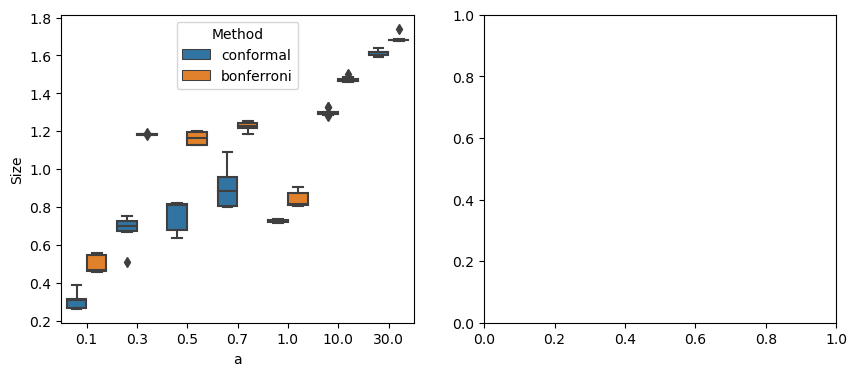

In [669]:
# Make plot
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.boxplot(data=res, x="a", y="Size", hue='Method', ax=ax[0])
ax[0].legend(loc='upper center', title='Method')

plt.show()

In [667]:
res = result[(result['Method']=='conformal') |(result['Method']=='bonferroni')]


In [664]:
selected_columns

,Pair_coverage,Coverage,Size,Inf_prop,Method,Calib_size,Train_size,Test_size,a,b,gamma,random_state
0,0.897,0.9000,0.310964,0.0,conformal,1250,2500.0,1000,0.1,100,0.99,0
0,0.946,0.9490,0.465283,0.0,bonferroni,1250,2500.0,1000,0.1,100,0.99,0
0,0.897,0.8990,0.311202,0.0,conformal,1250,2500.0,1000,0.1,100,0.99,1
0,0.953,0.9535,0.550396,0.0,bonferroni,1250,2500.0,1000,0.1,100,0.99,1
0,0.906,0.9070,0.265890,0.0,conformal,1250,2500.0,1000,0.1,100,0.99,2
...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.949,0.9540,1.682177,0.0,bonferroni,1250,2500.0,1000,30.0,100,0.99,7
0,0.914,0.9175,1.635820,0.0,conformal,1250,2500.0,1000,30.0,100,0.99,8
0,0.950,0.9535,1.740809,0.0,bonferroni,1250,2500.0,1000,30.0,100,0.99,8
0,0.904,0.9065,1.620544,0.0,conformal,1250,2500.0,1000,30.0,100,0.99,9
